<a href="https://colab.research.google.com/github/leocassiosilva/machine-learning/blob/main/classification_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Standard Libraries
import pandas as pd
import numpy as np
import json

# Data Preprocessing & NLP
import nltk
import re
import string
import gensim
from textblob import Word

import xgboost as xgb
from xgboost import XGBClassifier

from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier, BaggingRegressor, GradientBoostingClassifier,BaggingClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics.pairwise import linear_kernel

# Performance metrics
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, make_scorer, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics.pairwise import cosine_similarity

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
sns.set()
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


from google.colab import drive

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
news_df = pd.read_csv('/content/drive/MyDrive/analise_dados/bbc-text.csv')

In [5]:
news_df

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...
...,...,...
2220,business,cars pull down us retail figures us retail sal...
2221,politics,kilroy unveils immigration policy ex-chatshow ...
2222,entertainment,rem announce new glasgow concert us band rem h...
2223,politics,how political squabbles snowball it s become c...


In [6]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [7]:
news_df['category'].value_counts()


sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [8]:
#Associe os nomes de 'category' ao índice numérico e salve-o na nova coluna category_id
news_df['category_id'] = news_df['category'].factorize()[0]

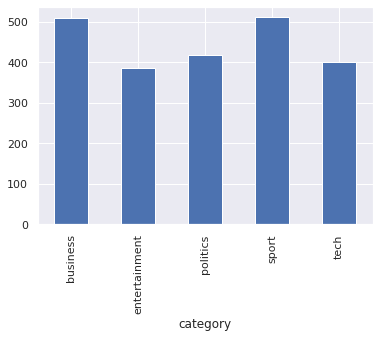

In [9]:
#Distribuição de artigos de notícias por categoria
news_df.groupby('category').category_id.count().plot.bar()

In [10]:
news_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   category     2225 non-null   object
 1   text         2225 non-null   object
 2   category_id  2225 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 52.3+ KB


In [11]:
# Crie um novo dataframe "category_id_df", que tem apenas categorias exclusivas, também classificando esta lista na ordem dos valores de category_id
category_id_df = news_df[['category', 'category_id']].drop_duplicates().sort_values('category_id')

# Crie um dicionário (estrutura de dados python - como uma tabela de pesquisa) que 
# pode facilmente converter nomes de categorias em category_ids e vice-versa
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)

category_to_id
#category_to_id['tech']

{'business': 1, 'entertainment': 3, 'politics': 4, 'sport': 2, 'tech': 0}

In [12]:
# Eliminar dados duplicados
news_df.drop_duplicates(subset=['category', 'text'], inplace=True)

In [13]:
news_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2126 entries, 0 to 2224
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   category     2126 non-null   object
 1   text         2126 non-null   object
 2   category_id  2126 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 66.4+ KB


In [14]:
# Limpeza de Dados
def clean_text(text):
    # remova tudo exceto alfabetos
    text = re.sub("[^a-zA-Z]", " ", text)
    # remover espaços em branco
    text = ' '.join(text.split())
    text = text.lower()
    
    return text

In [15]:
# criando uma coluna com texto limpo
news_df['clean_text'] = news_df['text'].apply(clean_text)

In [16]:
news_df.text[0]


'tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are also being built-in to high

In [17]:
news_df.clean_text[0]


'tv future in the hands of viewers with home theatre systems plasma high definition tvs and digital video recorders moving into the living room the way people watch tv will be radically different in five years time that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes with the us leading the trend programmes and other content will be delivered to viewers via home networks through cable satellite telecoms companies and broadband service providers to front rooms and portable devices one of the most talked about technologies of ces has been digital and personal video recorders dvr and pvr these set top boxes like the us s tivo and the uk s sky system allow people to record store play pause and forward wind tv programmes when they want essentially the technology allows for much more personalised tv they are also being built in to high definition tv sets which a

In [18]:
news_df.head()


,category,text,category_id,clean_text
0,tech,tv future in the hands of viewers with home th...,0,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...,1,worldcom boss left books alone former worldcom...
2,sport,tigers wary of farrell gamble leicester say ...,2,tigers wary of farrell gamble leicester say th...
3,sport,yeading face newcastle in fa cup premiership s...,2,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...,3,ocean s twelve raids box office ocean s twelve...


In [19]:
#https://www.nltk.org/
all_words = ' '.join([text for text in news_df['clean_text']])
all_words = all_words.split()
freq_dist = nltk.FreqDist(all_words)
words_df = pd.DataFrame({'word':list(freq_dist.keys()), 'count':list(freq_dist.values())})
words_df.head()   

,word,count
0,tv,498
1,future,353
2,in,17007
3,the,50385
4,hands,87


In [20]:
def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    
    #https://www.nltk.org/
    freq_dist = nltk.FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(freq_dist.keys()), 'count':list(freq_dist.values())})
    
    fig = plt.figure(figsize=(21,16))
    ax1 = fig.add_subplot(2,1,1)
    wordcloud = WordCloud(width=1000, height=300, background_color='black', 
                          max_words=1628, relative_scaling=1,
                          normalize_plurals=False).generate_from_frequencies(freq_dist)
    
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    
    ax2 = fig.add_subplot(2,1,2)
    d = words_df.nlargest(columns="count", n = terms) 
    ax2 = sns.barplot(data=d, palette = sns.color_palette('BuGn_r'), x= "count", y = "word")
    ax2.set(ylabel= 'Word')
    plt.show()

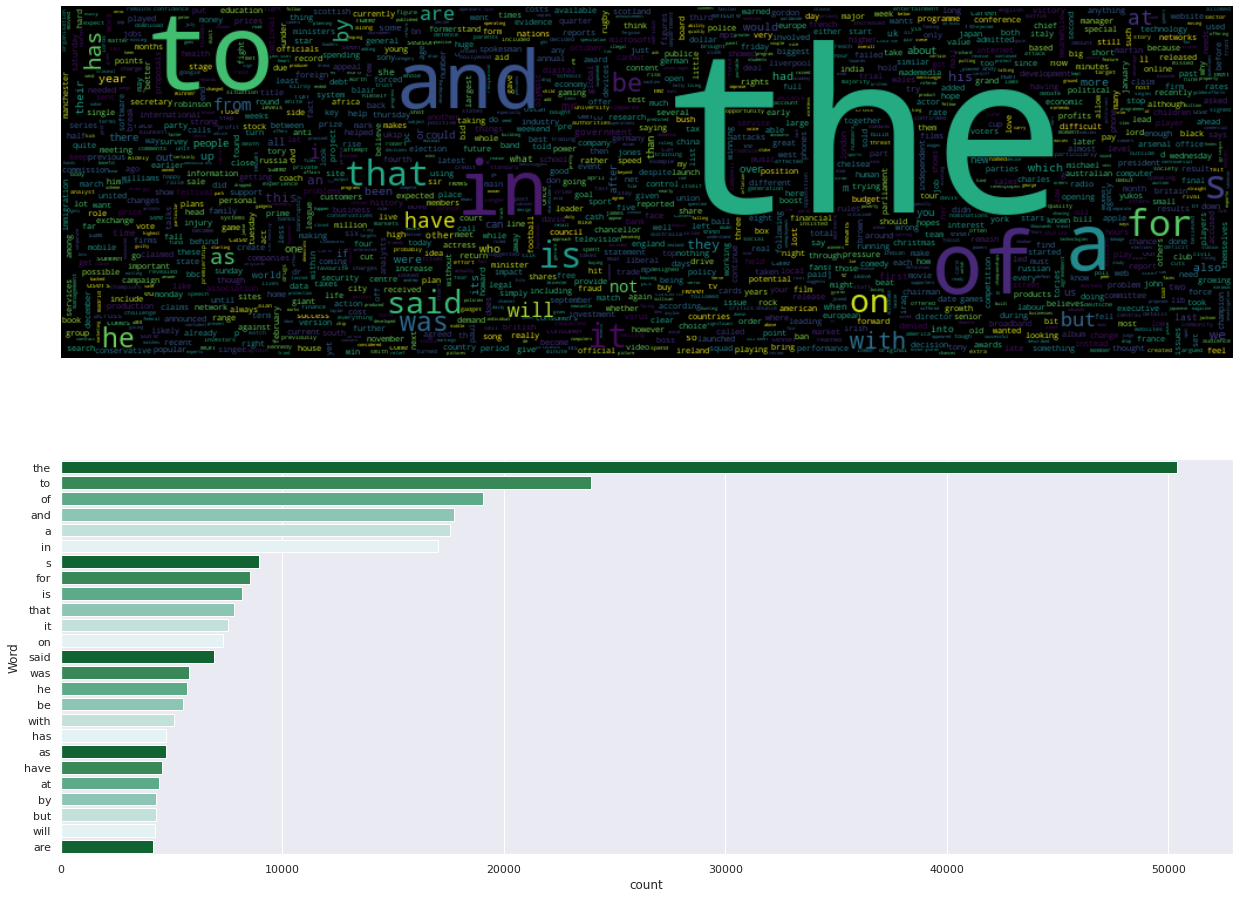

In [21]:
# plot 25 most frequent words including stop words
freq_words(news_df['clean_text'], 25)

In [23]:
#stop_words = set(stopwords.words('portuguese')) 
stop_words = set(stopwords.words('english'))
#stop_words

In [24]:
stop_wordsPTBR = set(stopwords.words('portuguese'))
#stop_wordsPTBR

In [25]:
# stopwords-to compare text data with and without stopwords

stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)
  
news_df['clean_text'] = news_df['clean_text'].apply(lambda x: remove_stopwords(x))

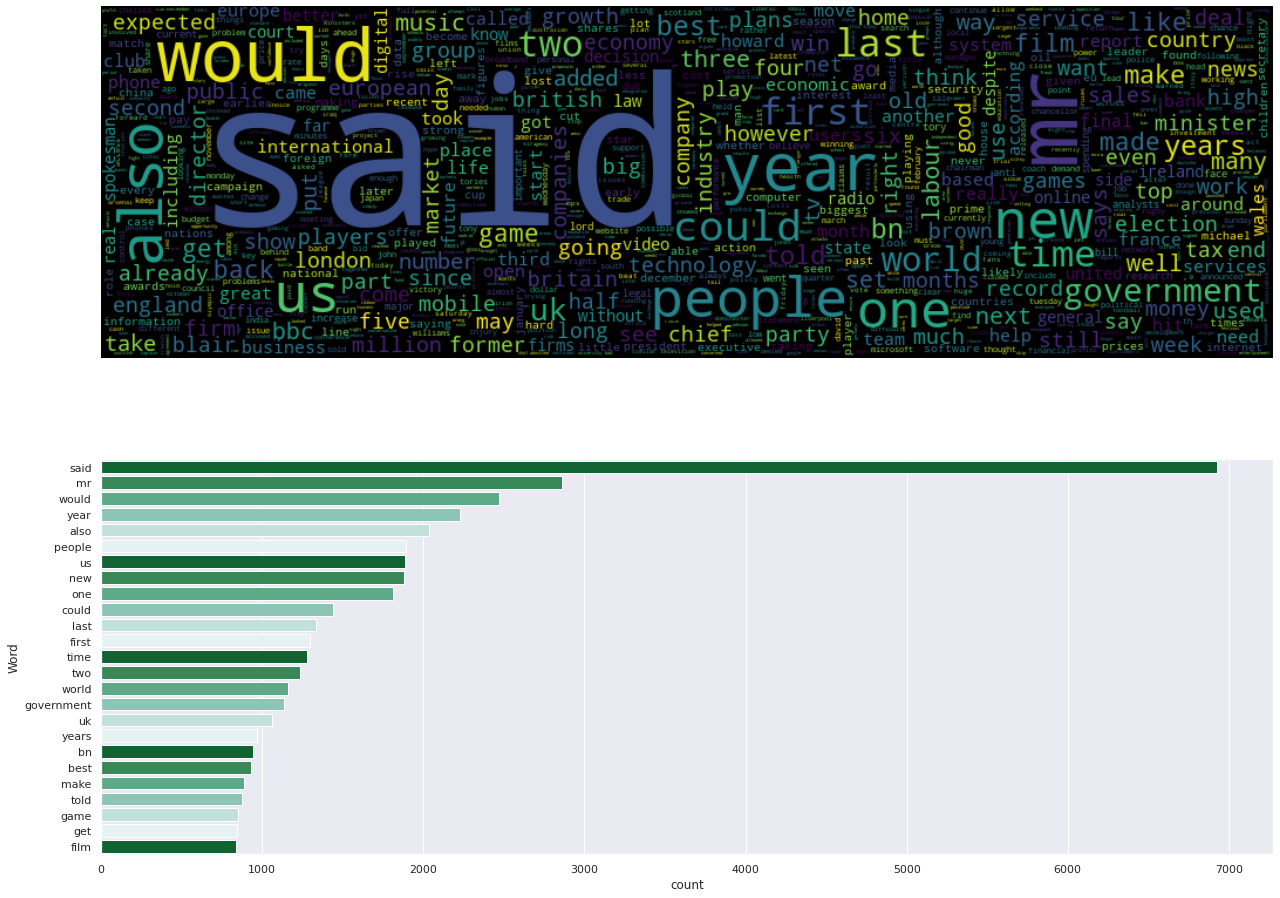

In [26]:
# plot 25 most frequent words without stopwords
freq_words(news_df['clean_text'], 25)

In [27]:
news_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2126 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   category     2126 non-null   object
 1   text         2126 non-null   object
 2   category_id  2126 non-null   int64 
 3   clean_text   2126 non-null   object
dtypes: int64(1), object(3)
memory usage: 147.6+ KB


Part 3: Heading to Machine Learning¶

In [28]:
# Processo de lematização
'''
Palavras na terceira pessoa são alteradas para primeira pessoa e os verbos no passado e no futuro são alterados para o presente pelo
processo de lematização.
'''
lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    lem = [lemmatizer.lemmatize(t) for t in filtered_tokens]
    return lem

In [29]:
# Defining a Count Vectorizer object
count_vec = CountVectorizer(stop_words='english', max_features=10000)
count_vec

CountVectorizer(max_features=10000, stop_words='english')

In [30]:
# Defining a TF-IDF Vectorizer
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), tokenizer=tokenize_and_lemmatize, max_features=10000, use_idf=True)
tfidf_vec

TfidfVectorizer(max_features=10000, ngram_range=(1, 2), stop_words='english',
                tokenizer=<function tokenize_and_lemmatize at 0x7fce5dad6cb0>)

In [31]:
features = tfidf_vec.fit_transform(news_df.clean_text).toarray() # Remaps the words in the 2225 articles in the text column of 
                                                  # data frame into features (superset of words) with an importance assigned 
                                                  # based on each words frequency in the document and across documents

labels = news_df.category_id                           # represents the category of each of the 2225 articles

In [32]:
#Get a feel of the features identified by tfidf
features.shape # How many features are there ? 

(2126, 10000)

In [33]:
# Remember the dictionary created to map category names to a number ? 
category_to_id.items()

dict_items([('tech', 0), ('business', 1), ('sport', 2), ('entertainment', 3), ('politics', 4)])

In [34]:
# The sorted function Converts dictionary items into a (sorted) list. 
# In subsequent steps - We will use this list to iterate over the categories
sorted(category_to_id.items())

[('business', 1),
 ('entertainment', 3),
 ('politics', 4),
 ('sport', 2),
 ('tech', 0)]

In [35]:
news_df

,category,text,category_id,clean_text
0,tech,tv future in the hands of viewers with home th...,0,tv future hands viewers home theatre systems p...
1,business,worldcom boss left books alone former worldc...,1,worldcom boss left books alone former worldcom...
2,sport,tigers wary of farrell gamble leicester say ...,2,tigers wary farrell gamble leicester say rushe...
3,sport,yeading face newcastle in fa cup premiership s...,2,yeading face newcastle fa cup premiership side...
4,entertainment,ocean s twelve raids box office ocean s twelve...,3,ocean twelve raids box office ocean twelve cri...
...,...,...,...,...
2220,business,cars pull down us retail figures us retail sal...,1,cars pull us retail figures us retail sales fe...
2221,politics,kilroy unveils immigration policy ex-chatshow ...,4,kilroy unveils immigration policy ex chatshow ...
2222,entertainment,rem announce new glasgow concert us band rem h...,3,rem announce new glasgow concert us band rem a...
2223,politics,how political squabbles snowball it s become c...,4,political squabbles snowball become commonplac...


In [36]:
news_df.to_csv('out_df.csv', index=False)
news_df

,category,text,category_id,clean_text
0,tech,tv future in the hands of viewers with home th...,0,tv future hands viewers home theatre systems p...
1,business,worldcom boss left books alone former worldc...,1,worldcom boss left books alone former worldcom...
2,sport,tigers wary of farrell gamble leicester say ...,2,tigers wary farrell gamble leicester say rushe...
3,sport,yeading face newcastle in fa cup premiership s...,2,yeading face newcastle fa cup premiership side...
4,entertainment,ocean s twelve raids box office ocean s twelve...,3,ocean twelve raids box office ocean twelve cri...
...,...,...,...,...
2220,business,cars pull down us retail figures us retail sal...,1,cars pull us retail figures us retail sales fe...
2221,politics,kilroy unveils immigration policy ex-chatshow ...,4,kilroy unveils immigration policy ex chatshow ...
2222,entertainment,rem announce new glasgow concert us band rem h...,3,rem announce new glasgow concert us band rem a...
2223,politics,how political squabbles snowball it s become c...,4,political squabbles snowball become commonplac...


In [37]:
# Use chi-square analysis to find corelation between features (importantce of words) and labels(news category) 
from sklearn.feature_selection import chi2

N = 3  # We are going to look for top 3 categories

#For each category, find words that are highly corelated to it
for category, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)                   # Do chi2 analyses of all items in this category
    indices = np.argsort(features_chi2[0])                                  # Sorts the indices of features_chi2[0] - the chi-squared stats of each feature
    feature_names = np.array(tfidf_vec.get_feature_names())[indices]            # Converts indices to feature names ( in increasing order of chi-squared stat values)
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]         # List of single word features ( in increasing order of chi-squared stat values)
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]          # List for two-word features ( in increasing order of chi-squared stat values)
    print("# '{}':".format(category))
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:]))) # Print 3 unigrams with highest Chi squared stat
    print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:]))) # Print 3 bigrams with highest Chi squared stat

# 'business':
  . Most correlated unigrams:
       . oil
       . bank
       . bn
  . Most correlated bigrams:
       . economic growth
       . stock market
       . bn bn
# 'entertainment':
  . Most correlated unigrams:
       . oscar
       . award
       . film
  . Most correlated bigrams:
       . los angeles
       . film festival
       . box office
# 'politics':
  . Most correlated unigrams:
       . blair
       . election
       . labour
  . Most correlated bigrams:
       . prime minister
       . mr brown
       . mr blair
# 'sport':
  . Most correlated unigrams:
       . champion
       . cup
       . match
  . Most correlated bigrams:
       . australian open
       . champion league
       . grand slam
# 'tech':
  . Most correlated unigrams:
       . technology
       . user
       . mobile
  . Most correlated bigrams:
       . high definition
       . mobile phone
       . e mail


In [38]:
features_chi2

(array([1.06501349e-01, 1.03261752e-01, 9.01711479e-02, ...,
        3.02079118e-05, 9.40565905e-02, 1.34770864e-01]),
 array([0.74416301, 0.74794997, 0.76395969, ..., 0.99561471, 0.75908203,
        0.71353584]))

In [39]:
news_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2126 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   category     2126 non-null   object
 1   text         2126 non-null   object
 2   category_id  2126 non-null   int64 
 3   clean_text   2126 non-null   object
dtypes: int64(1), object(3)
memory usage: 147.6+ KB


In [40]:
X = news_df.loc[:,'clean_text']
y = news_df.loc[:,'category_id']

In [41]:
# Basic validation: splitting the data 80-20-20 train/test
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, news_df.index, test_size=0.2, random_state=55)
#X_train, X_cv, y_train, y_cv = train_test_split(X,y,test_size=.25, random_state=10)

In [42]:
# Tf-Idf transformation 
xtrain_tfidf = tfidf_vec.fit_transform(X_train)
xtest_tfidf = tfidf_vec.transform(X_test)
#xcv_tfidf = tfidf_vec.fit_transform(X_cv)
xtrain_tfidf.shape

(1700, 10000)

In [43]:
# Count Vectorizer transformation
xtrain_cv = count_vec.fit_transform(X_train)
xtest_cv = count_vec.transform(X_test)
xtrain_cv.shape

(1700, 10000)

Part 4: Model Training and Evaluation¶


In [44]:
#create list of model and accuracy dicts
perform_list = []

In [45]:
def run_model(model_name, est_c, est_pnlty):
    mdl=''
    if model_name == 'Logistic Regression':
        mdl = LogisticRegression()
    elif model_name == 'Random Forest':
        mdl = RandomForestClassifier(n_estimators=100)
    elif model_name == 'Multinomial Naive Bayes':
        mdl = MultinomialNB()
    elif model_name == 'Linear SVC':
        mdl = LinearSVC()
    elif model_name == 'Logistic Regression GridSearchCV':
        mdl = LogisticRegression(C=est_c, penalty=est_pnlty)        

    oneVsRest = OneVsRestClassifier(mdl)
    oneVsRest.fit(xtrain_tfidf, y_train)
    y_pred = oneVsRest.predict(xtest_tfidf)
    
    
    # Performance metrics
    accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
    # Get precision, recall, f1 scores
    precision, recall, f1score, support = score(y_test, y_pred, average='micro')

    print(f'Test Accuracy Score of Basic {model_name}: % {accuracy}')
    print(f'Precision : {precision}')
    print(f'Recall    : {recall}')
    print(f'F1-score   : {f1score}')

    # Add performance parameters to list
    perform_list.append(dict([
        ('Model', model_name),
        ('Test Accuracy', round(accuracy, 2)),
        ('Precision', round(precision, 2)),
        ('Recall', round(recall, 2)),
        ('F1', round(f1score, 2))
         ]))

In [46]:
run_model('Random Forest', est_c=None, est_pnlty=None)


Test Accuracy Score of Basic Random Forest: % 95.77
Precision : 0.9577464788732394
Recall    : 0.9577464788732394
F1-score   : 0.9577464788732394


In [47]:
run_model('Logistic Regression', est_c=None, est_pnlty=None)


Test Accuracy Score of Basic Logistic Regression: % 96.48
Precision : 0.9647887323943662
Recall    : 0.9647887323943662
F1-score   : 0.9647887323943662


In [48]:
run_model('Multinomial Naive Bayes', est_c=None, est_pnlty=None)


Test Accuracy Score of Basic Multinomial Naive Bayes: % 96.95
Precision : 0.9694835680751174
Recall    : 0.9694835680751174
F1-score   : 0.9694835680751174


In [49]:
run_model('Linear SVC', est_c=None, est_pnlty=None)


Test Accuracy Score of Basic Linear SVC: % 97.42
Precision : 0.9741784037558685
Recall    : 0.9741784037558685
F1-score   : 0.9741784037558685


Performance metrics of models


In [50]:
model_performance = pd.DataFrame(data=perform_list)
model_performance = model_performance[['Model', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
model_performance

,Model,Test Accuracy,Precision,Recall,F1
0,Random Forest,95.77,0.96,0.96,0.96
1,Logistic Regression,96.48,0.96,0.96,0.96
2,Multinomial Naive Bayes,96.95,0.97,0.97,0.97
3,Linear SVC,97.42,0.97,0.97,0.97


Fonte
https://www.kaggle.com/alyssonbispopereira/classifica-o-de-texto